In [1]:
import numpy as np
from skyfield.api import Topos, load, EarthSatellite
import datetime
import pytz
import matplotlib.pyplot as plt
from functools import lru_cache
import passpredict
from passpredict import OMM, Satellite, Location


/home/sam/passpredict/venv/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
# Topographic location
lat, lon, h = 30.2711, -97.7437, 0
austin = Topos(latitude=lat, longitude=lon, elevation_m=h)

In [3]:
# TLE for ISS
tle1 = "1 25544U 98067A   20154.57277630  .00016717  00000-0  10270-3 0  9118"
tle2 = "2 25544  51.6443  60.8122 0001995  12.6931 347.4269 15.49438452 29742"
satellite = EarthSatellite(tle1, tle2, "ISS")

In [4]:
# time period
datetime_start = datetime.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
datetime_end = datetime.datetime(2020, 6, 11, 0, 0, 0, tzinfo=pytz.utc)
seconds_between = int((datetime_end-datetime_start).total_seconds())
dt_seconds = 5
ts = load.timescale().utc(2020, 6, 1, 0, 0, np.arange(0,seconds_between, dt_seconds))  # skyfield timescale

In [5]:
rho = satellite - austin

In [6]:
satellite_position = satellite.at(ts)
# p2.itrf_xyz().km
skyfield_rECEF = np.array(satellite_position.itrf_xyz().km)
import pytz
central = pytz.timezone('US/Central')
dt = ts.astimezone(central)

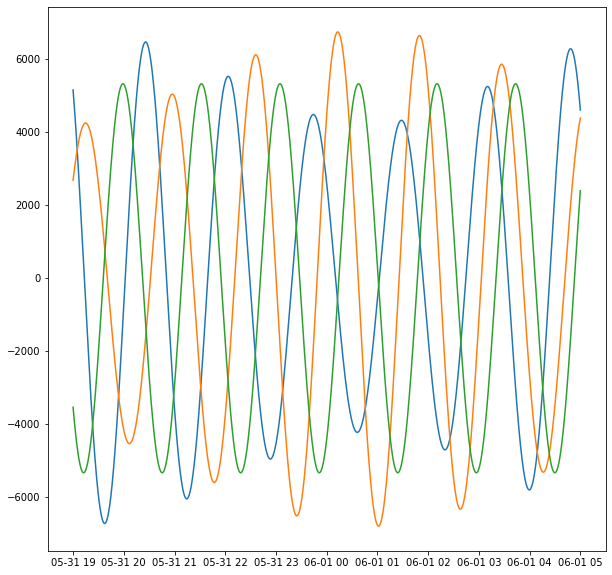

In [30]:
# plot results
slc = slice(1440 * 5)
plt.figure(figsize=(10,10))
plt.plot(dt[slc], skyfield_rECEF.T[slc])
plt.show()

In [16]:
import time
omm = OMM.from_tle(tle1, tle2)
satellite = Satellite(omm)
jd0 = satellite.epoch
jd = np.linspace(jd0, jd0 + 2, 1440 * 2)
r = np.zeros((jd.size, 3))
t1 = time.perf_counter()
for i in range(jd.size):
    r[i] = satellite.propagate(jd[i])
t2 = time.perf_counter()
print(f'Time: {(t2-t1)*1000:f} ms')

Time: 30.391431 ms


In [19]:
r[:,2]

array([9219.34573491, 9219.34567358, 9219.34561226, ..., 9219.16930694,
       9219.16924562, 9219.16918429])

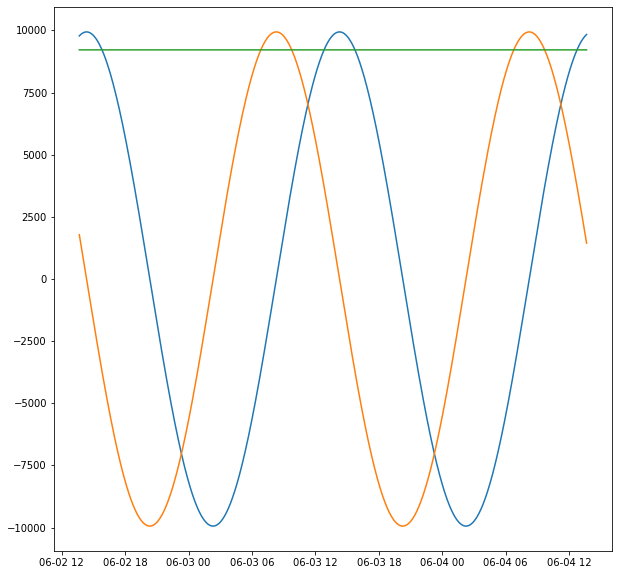

In [22]:
# plot results
from passpredict.timefn import jday2datetime
dt = [jday2datetime(j - 5/1440.0) for j in jd]
plt.figure(figsize=(10,10))
plt.plot(dt, r)
plt.show()

In [14]:
import time
from passpredict.predict_py import Observer
omm = OMM.from_tle(tle1, tle2)
satellite = Satellite(omm)
location = Location(30.1957, -97.8649, 0)
observer = Observer(location, satellite)
jd0 = satellite.epoch
ndays = 10
jd = np.linspace(jd0, jd0 + ndays, 1440 * ndays)
el = np.zeros(jd.size)
t1 = time.perf_counter()
for i in range(jd.size):
    el[i] = observer.compute_elevation(jd[i])
t2 = time.perf_counter()
print(f'Time: {(t2-t1)*1000:f} ms')

Time: 132.953259 ms


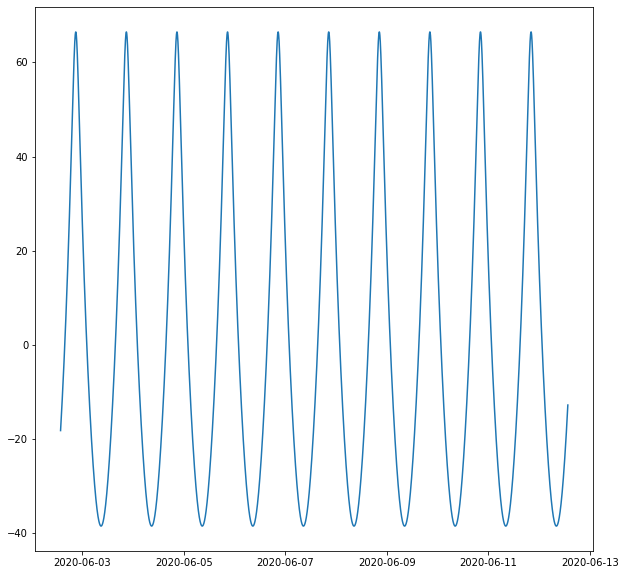

In [15]:
# plot results
from passpredict.timefn import jday2datetime
dt = [jday2datetime(j - 5/1440.0) for j in jd]
plt.figure(figsize=(10,10))
plt.plot(dt, el)
plt.show()

In [ ]:
# Save skyfield data for later
# np.save('passpredict/tests/data/skyfield_iss_rECEF',skyfield_rECEF, allow_pickle=True, fix_imports=True)


In [ ]:
diff = skyfield_rECEF - passpredict_rECEF
datetime_array = np.arange(datetime_start, datetime_end, np.timedelta64(dt_seconds, 's'))
print(datetime_array)

['2020-06-01T00:00:00.000000' '2020-06-01T00:00:05.000000'
 '2020-06-01T00:00:10.000000' ... '2020-06-10T23:59:45.000000'
 '2020-06-10T23:59:50.000000' '2020-06-10T23:59:55.000000']


In [ ]:
x=np.linalg.norm(diff, axis=0)
diff.shape

(3, 172800)

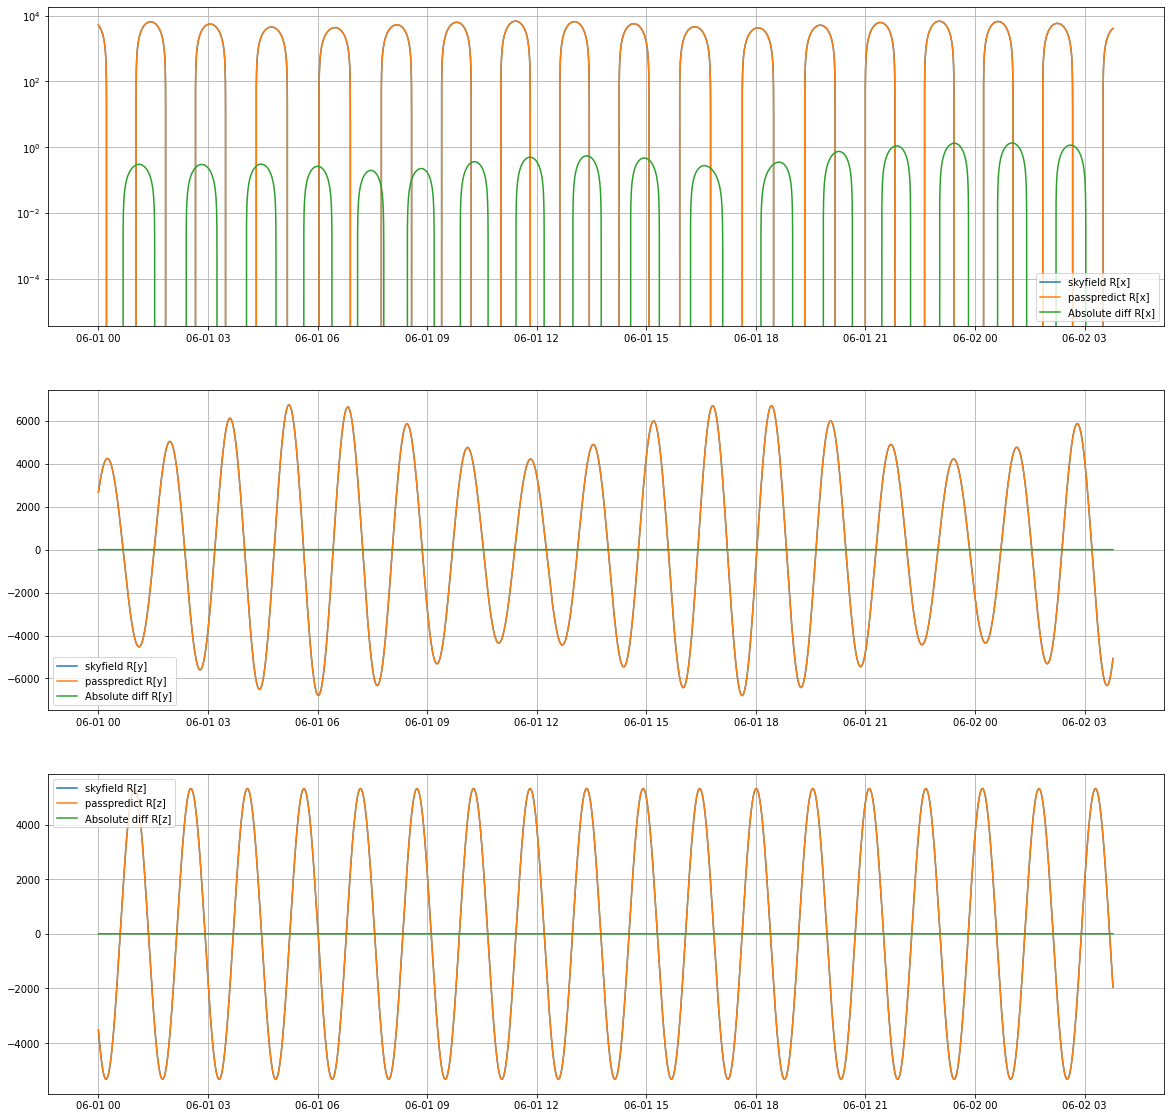

In [ ]:
idx = np.arange(0, 20000, dtype=np.int32)
# idx = np.arange(0, n)
%matplotlib inline

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,1, 1)
ax.plot(datetime_array[idx], skyfield_rECEF[0][idx], label='skyfield R[x]')
ax.plot(datetime_array[idx], passpredict_rECEF[0][idx], label='passpredict R[x]')
ax.plot(datetime_array[idx], skyfield_rECEF[0][idx]-passpredict_rECEF[0][idx], label='Absolute diff R[x]')
ax.legend()
ax.grid()

ax1 = fig.add_subplot(3,1,2)
ax1.plot(datetime_array[idx], skyfield_rECEF[1][idx], label='skyfield R[y]')
ax1.plot(datetime_array[idx], passpredict_rECEF[1][idx], label='passpredict R[y]')
ax1.plot(datetime_array[idx], skyfield_rECEF[1][idx]-passpredict_rECEF[1][idx], label='Absolute diff R[y]')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(3,1,3)
ax2.plot(datetime_array[idx], skyfield_rECEF[2][idx], label='skyfield R[z]')
ax2.plot(datetime_array[idx], passpredict_rECEF[2][idx], label='passpredict R[z]')
ax2.plot(datetime_array[idx], skyfield_rECEF[2][idx]-passpredict_rECEF[2][idx], label='Absolute diff R[z]')
ax2.legend()
ax2.grid()

plt.show()